<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
!pip install numpy==1.24.4


In [113]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2025-04-26 17:46:23--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-04-26 17:46:23--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2025-04-26 17:46:24 (13.5 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-04-26 17:46:24--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.002s (13.5 MB/s)


In [6]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [7]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        #valid_data, valid_target = iter(valid_loader).next() Version vieja
        valid_data, valid_target = next(iter(valid_loader))

        output = model(valid_data.to(device)).cpu()

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset las peliculas de los avengers

In [8]:
def load_avengers_scripts(paths, names=None, encoding="latin-1"):
    """
    Carga líneas de varios scripts en un DataFrame.
    Si names se provee, agrega columna 'movie' con el nombre correspondiente.
    """
    records = []
    for path, name in zip(paths, names or [None]*len(paths)):
        with open(path, encoding=encoding) as f:
            for line in f:
                txt = line.strip()
                if not txt:
                    continue
                rec = {"texto": txt}
                if name is not None:
                    rec["movie"] = name
                records.append(rec)
    return pd.DataFrame(records)


In [23]:
def get_char_tokens(df, text_col="texto", lower=True):
    """
    - Concatena todo el texto en un único string.
    - Opcionalmente lo pasa a minúsculas.
    - Inserta espacios entre cada carácter.
    - Tokeniza carácter a carácter usando text_to_word_sequence.
    """
    # 1. Corpus como un solo string
    corpus = df[text_col].str.cat(sep="")
    if lower:
        corpus = corpus.lower()
    # 2. Separar cada carácter con un espacio
    spaced = " ".join(list(corpus))
    # 3. text_to_word_sequence con filtros vacíos para no descartar nada
    return text_to_word_sequence(spaced, filters="", lower=False, split=" ")


In [10]:
file_paths = [
        "/content/Avengers.Age.of.Ultron.txt",
        "/content/Avengers.Endgame.txt",
        "/content/Avengers.Infinity.War.txt",
        "/content/Avengers.txt"
    ]

movie_names = [
    "Avengers: Age of Ultron",
    "Avengers: Endgame",
    "Avengers: Infinity War",
    "The Avengers"
]

df = load_avengers_scripts(file_paths, movie_names)

print(df.head())
print(f"\nTotal de líneas combinadas: {len(df)}")

                                               texto                    movie
0                                (DISTANT EXPLOSION)  Avengers: Age of Ultron
1  STRUCKER ON PA: Report to your stations immedi...  Avengers: Age of Ultron
2                               This is not a drill.  Avengers: Age of Ultron
3                               We are under attack!  Avengers: Age of Ultron
4                   (SOLDIERS SHOUTING INDISTINCTLY)  Avengers: Age of Ultron

Total de líneas combinadas: 7793


In [11]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 7793


## 1 - Preprocesamiento de datos

### Vistazo a las primeras filas

In [12]:
df.iloc[:15,0]

,texto
0,(DISTANT EXPLOSION)
1,STRUCKER ON PA: Report to your stations immedi...
2,This is not a drill.
3,We are under attack!
4,(SOLDIERS SHOUTING INDISTINCTLY)
5,We are under attack!
6,(GRUNTS)
7,(POWERING UP)
8,(YELLS)
9,(GRUNTING)


### Concatenamos todos los rows en un solo valor

In [19]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

<ipython-input-19-9eca7dd73672>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]


In [28]:
tokens = get_char_tokens(df)
print(tokens[:20])

['(', 'd', 'i', 's', 't', 'a', 'n', 't', 'e', 'x', 'p', 'l', 'o', 's', 'i', 'o', 'n', ')', 's', 't']


### Transformar el corpus a tokens

In [29]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 185527


In [49]:
def build_dataset(text_sequences):
    """
    text_sequences: list[list[token]] de longitud train_len
    Devuelve:
      - X: LongTensor (n_samples, train_len-1)
      - y_idx: LongTensor (n_samples,) en 0...(vocab_size-1)
      - vocab_size: int
      - tokenizer: Tokenizer ajustado (útil para inversión o embedding)
    """
    # 1) Ajustar el tokenizer (sin filtros, case-sensitive)
    tok = Tokenizer(filters='', lower=False, split=' ')
    tok.fit_on_texts(text_sequences)

    # 2) A números y matriz numpy
    sequences = tok.texts_to_sequences(text_sequences)
    arr = np.array(sequences, dtype=np.int64)

    # 3) X = todas menos la última posición; y_idx = última posición – 1
    X_np = arr[:, :-1]
    y_idx_np = arr[:,  -1] - 1

    # 4) Convertir a tensores Long
    X = torch.from_numpy(X_np).long()
    y_idx = torch.from_numpy(y_idx_np).long()

    # 5) Vocab size
    vocab_size = len(tok.word_index)

    return X, y_idx, vocab_size, tok,sequences

In [44]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [45]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['(', 'd', 'i', 's'],
 ['d', 'i', 's', 't'],
 ['i', 's', 't', 'a'],
 ['s', 't', 'a', 'n'],
 ['t', 'a', 'n', 't'],
 ['a', 'n', 't', 'e'],
 ['n', 't', 'e', 'x'],
 ['t', 'e', 'x', 'p'],
 ['e', 'x', 'p', 'l'],
 ['x', 'p', 'l', 'o'],
 ['p', 'l', 'o', 's'],
 ['l', 'o', 's', 'i'],
 ['o', 's', 'i', 'o'],
 ['s', 'i', 'o', 'n'],
 ['i', 'o', 'n', ')'],
 ['o', 'n', ')', 's'],
 ['n', ')', 's', 't'],
 [')', 's', 't', 'r'],
 ['s', 't', 'r', 'u'],
 ['t', 'r', 'u', 'c']]

## Generar Input y Target

In [55]:
X, y, vocab_size, tok,sequences = build_dataset(text_sequences)
print("X shape:", X.shape)       # (n_samples, train_len-1)
print("y shape:", y.shape)       # (n_samples, vocab_size)
print("Vocab size:", vocab_size)

X shape: torch.Size([185523, 3])
y shape: torch.Size([185523])
Vocab size: 52


In [56]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 185523


In [60]:
tok.index_word

{1: 'e',
 2: 't',
 3: 'o',
 4: 'a',
 5: 'i',
 6: 'n',
 7: 's',
 8: 'h',
 9: 'r',
 10: '.',
 11: 'l',
 12: 'u',
 13: 'd',
 14: 'y',
 15: 'g',
 16: 'w',
 17: 'm',
 18: 'c',
 19: 'f',
 20: "'",
 21: 'p',
 22: ',',
 23: 'b',
 24: 'k',
 25: 'v',
 26: '?',
 27: '-',
 28: '!',
 29: ')',
 30: '(',
 31: 'j',
 32: ':',
 33: 'x',
 34: '"',
 35: 'q',
 36: '0',
 37: 'z',
 38: '1',
 39: '2',
 40: '3',
 41: '7',
 42: '4',
 43: '%',
 44: '5',
 45: '9',
 46: '8',
 47: '6',
 48: '&',
 49: 'ö',
 50: 'ø',
 51: 'ã',
 52: 'ï'}

Aclaracion:

No realice one-hot encoding porque CrossEntropyLoss no lo necesita. Esta función espera que las etiquetas sean índices enteros de clase, no vectores. Si hiciéramos one-hot, estaríamos pasando un formato incorrecto y el loss no funcionaría como corresponde.

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [64]:
class Data(Dataset):
    def __init__(self, x, y):
        """
        x: np.ndarray o torch.Tensor de shape (N, seq_len)
        y: np.ndarray o torch.Tensor de shape (N,) con índices 0…vocab_size-1
        """
        # Entradas como LongTensor
        if torch.is_tensor(x):
            self.x = x.long()
        else:
            self.x = torch.tensor(x, dtype=torch.long)

        # Targets como LongTensor (índices de clase)
        if torch.is_tensor(y):
            self.y = y.long()
        else:
            self.y = torch.tensor(y, dtype=torch.long)

        self.len = self.y.size(0)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

In [65]:
data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

#output_dim = data_set.y.shape[1]
output_dim = vocab_size

print("Output dim", output_dim)

input_size: 3
Output dim 52


In [66]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 148419
Tamaño del conjunto de validacion: 37104


## 3 - Entrenar el modelo

Aclaraciones:

Hice algunas modifiicaciones en el dropout para evitar overfitting

No usamos softmax en la última capa porque CrossEntropyLoss ya lo aplica internamente. Si lo agregábamos nosotros, estaríamos duplicando esa operación, lo cual puede generar inestabilidad numérica y hacer que el modelo aprenda peor. Por eso dejamos que la última capa devuelva directamente los logits.

In [67]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.5) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:]))
        #out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

In [74]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model1.cuda()

model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-4)

model1_criterion = torch.nn.CrossEntropyLoss()


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)


### Summary

In [76]:
input_tensor = data_set[0][0].unsqueeze(0).to(device)

# Mostrar resumen del modelo
summary(model1, input_data=input_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 52]                   --
├─Embedding: 1-1                         [1, 3, 5]                 265
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 52]                   1,716
Total params: 55,517
Trainable params: 55,517
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22

In [71]:
def categorical_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=1, keepdim=True)[1]
    y_test_tag = y_test.view(-1, 1)
    correct_results_sum = (y_pred_tag == y_test_tag).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc


In [77]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=30
                )

Epoch: 1/30 - Train loss 2.892 - Train accuracy 0.173 - Valid Loss 2.688 - Valid accuracy 0.232
Epoch: 2/30 - Train loss 2.606 - Train accuracy 0.254 - Valid Loss 2.526 - Valid accuracy 0.279
Epoch: 3/30 - Train loss 2.469 - Train accuracy 0.289 - Valid Loss 2.451 - Valid accuracy 0.293
Epoch: 4/30 - Train loss 2.379 - Train accuracy 0.309 - Valid Loss 2.394 - Valid accuracy 0.308
Epoch: 5/30 - Train loss 2.321 - Train accuracy 0.325 - Valid Loss 2.356 - Valid accuracy 0.314
Epoch: 6/30 - Train loss 2.284 - Train accuracy 0.337 - Valid Loss 2.337 - Valid accuracy 0.322
Epoch: 7/30 - Train loss 2.254 - Train accuracy 0.343 - Valid Loss 2.315 - Valid accuracy 0.324
Epoch: 8/30 - Train loss 2.234 - Train accuracy 0.349 - Valid Loss 2.309 - Valid accuracy 0.326
Epoch: 9/30 - Train loss 2.216 - Train accuracy 0.353 - Valid Loss 2.285 - Valid accuracy 0.330
Epoch: 10/30 - Train loss 2.203 - Train accuracy 0.357 - Valid Loss 2.280 - Valid accuracy 0.333
Epoch: 11/30 - Train loss 2.190 - Train

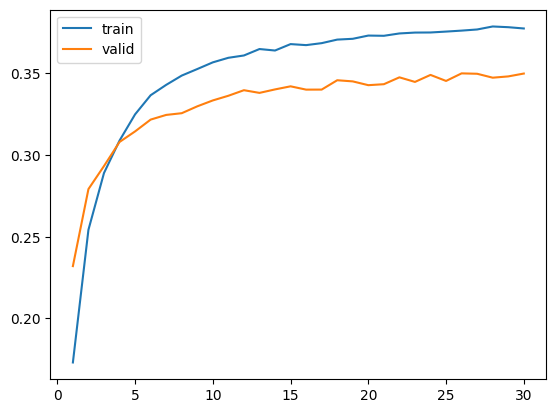

In [78]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [79]:
# Guarda solo los pesos del modelo
torch.save(model1.state_dict(), "model1_weights.pth")


## Cargar modelo

In [80]:
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)
model1.load_state_dict(torch.load("model1_weights.pth"))
model1.to(device)
model1.eval()


Model1(
  (embedding): Embedding(53, 5, padding_idx=0)
  (lstm1): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=52, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

## 4 - Predicción de próxima palabra

In [89]:
def predict_next_char(model, tokenizer, input_char, max_len=3):
    """
    Predice la próxima palabra dada una frase de entrada.

    Args:
        model (torch.nn.Module): Modelo entrenado.
        tokenizer (Tokenizer): Tokenizador ya ajustado.
        input_text (str): Frase inicial.
        max_len (int): Longitud máxima de entrada (usada en pad_sequences).

    Returns:
        str: Frase con la palabra predicha añadida.
    """
    model.eval()
    input_char = " ".join(list(input_char.lower()))

    # Tokenizar y preprocesar
    encoded = tokenizer.texts_to_sequences([input_char])[0]
    padded = pad_sequences([encoded], maxlen=max_len, padding='pre')
    tensor = torch.from_numpy(padded.astype(np.int32)).to(device)

    # Predecir
    with torch.no_grad():
        output = model(tensor)
        predicted_idx = output.argmax(dim=-1).item()

    predicted_word = None
    for word, index in tokenizer.word_index.items():
        if index == predicted_idx + 1:
            predicted_word = word
            break

    predicted_word = predicted_word if predicted_word is not None else "<UNK>"

    return input_char + " " + predicted_word


In [91]:
input_text = "brin"
output = predict_next_char(model1, tok, input_text)
print(output)


b r i n g


In [92]:
input_text = "hel"
output = predict_next_char(model1, tok, input_text)
print(output)

h e l l


In [93]:
input_text = "i a"
output = predict_next_char(model1, tok, input_text)
print(output)

i   a m


In [94]:
input_text = "ton"
output = predict_next_char(model1, tok, input_text)
print(output)

t o n e


por alguna razon siempre predeci que la siguiente palabra es defeating. Por lo que el modelo no es el mejor.

## 5 - Generación de secuencias nuevas

In [101]:
def generate_seq(model, tokenizer, seed_text, max_length, n_char):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_char (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_char" agregadas
    """
    seed_text = " ".join(list(seed_text.lower()))
    output_text = seed_text
	# generate a fixed number of char
    for _ in range(n_char):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)
        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_char = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for char, index in tokenizer.word_index.items():
            if index == y_hat:
                out_char = char
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_char
    return output_text

In [103]:
input_text='i a'

generate_seq(model1, tok, input_text, max_length=3, n_char=2)

'i   a w '

## 6 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

Voy a aplicar las siguientes recomendaciones para ver si mejora el modelo:

In [104]:
class ModelBonus(Model1):
    def __init__(self, vocab_size, output_dim):
        super().__init__(vocab_size, output_dim)

        self.bidirectional = True
        self.embedding_dim = 5
        self.lstm_size = 32
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1,
                                      embedding_dim=self.embedding_dim,
                                      padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim,
                             hidden_size=self.lstm_size,
                             num_layers=self.num_layers,
                             dropout=0.6,
                             batch_first=True,
                             bidirectional=self.bidirectional)

        # Ajustamos los Linear para bidireccional
        self.fc1 = nn.Linear(in_features=self.lstm_size * 2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim)

        self.relu = nn.ReLU()

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:, -1, :]))
        out = self.fc2(out)  # sin softmax porque usamos CrossEntropy
        return out

    def init_hidden(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        return (
            torch.zeros(self.num_layers * num_directions, batch_size, self.lstm_size).to(device),
            torch.zeros(self.num_layers * num_directions, batch_size, self.lstm_size).to(device),
        )


In [105]:
model2 = ModelBonus(vocab_size=vocab_size, output_dim=output_dim)
if cuda: model2.cuda()

model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-5)

model2_criterion = torch.nn.CrossEntropyLoss()

In [106]:
model2 = model2.to(device)

In [107]:
# Mostrar resumen del modelo
summary(model2, input_data=input_tensor)

Layer (type:depth-idx)                   Output Shape              Param #
ModelBonus                               [1, 52]                   --
├─Embedding: 1-1                         [1, 3, 5]                 265
├─LSTM: 1-2                              [1, 3, 64]                35,072
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 52]                   1,716
Total params: 39,133
Trainable params: 39,133
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.16

In [108]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=30
                )

Epoch: 1/30 - Train loss 2.839 - Train accuracy 0.191 - Valid Loss 2.665 - Valid accuracy 0.232
Epoch: 2/30 - Train loss 2.612 - Train accuracy 0.245 - Valid Loss 2.568 - Valid accuracy 0.258
Epoch: 3/30 - Train loss 2.520 - Train accuracy 0.269 - Valid Loss 2.513 - Valid accuracy 0.268
Epoch: 4/30 - Train loss 2.460 - Train accuracy 0.283 - Valid Loss 2.467 - Valid accuracy 0.283
Epoch: 5/30 - Train loss 2.418 - Train accuracy 0.293 - Valid Loss 2.441 - Valid accuracy 0.290
Epoch: 6/30 - Train loss 2.386 - Train accuracy 0.304 - Valid Loss 2.418 - Valid accuracy 0.301
Epoch: 7/30 - Train loss 2.361 - Train accuracy 0.310 - Valid Loss 2.407 - Valid accuracy 0.303
Epoch: 8/30 - Train loss 2.343 - Train accuracy 0.315 - Valid Loss 2.393 - Valid accuracy 0.303
Epoch: 9/30 - Train loss 2.326 - Train accuracy 0.320 - Valid Loss 2.373 - Valid accuracy 0.308
Epoch: 10/30 - Train loss 2.313 - Train accuracy 0.323 - Valid Loss 2.369 - Valid accuracy 0.309
Epoch: 11/30 - Train loss 2.301 - Train

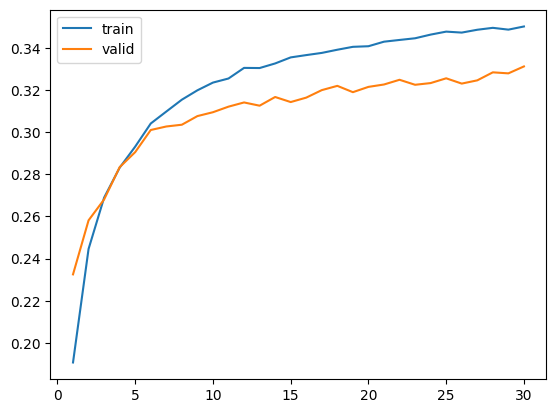

In [109]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

In [110]:
torch.save(model2.state_dict(), "model2_weights.pth")

In [111]:
test_phrases = [
    "bri",
    "hi",
    "i a",
    "ton",
    "i a",
    "we",
    "i ",
    "ave",
    "wha",
    "you",
    "i l"
]


for text in test_phrases:
    output = predict_next_char(model2, tok, text)
    print(f"Input:  {text}")
    print(f"Output: {output}")
    print("-" * 40)


Input:  bri
Output: b r i n
----------------------------------------
Input:  hi
Output: h i s
----------------------------------------
Input:  i a
Output: i   a t
----------------------------------------
Input:  ton
Output: t o n e
----------------------------------------
Input:  i a
Output: i   a t
----------------------------------------
Input:  we
Output: w e '
----------------------------------------
Input:  i 
Output: i   g
----------------------------------------
Input:  ave
Output: a v e t
----------------------------------------
Input:  wha
Output: w h a t
----------------------------------------
Input:  you
Output: y o u '
----------------------------------------
Input:  i l
Output: i   l l
----------------------------------------


In [112]:
for text in test_phrases:
    output = predict_next_char(model1, tok, text)
    print(f"Input:  {text}")
    print(f"Output: {output}")
    print("-" * 40)


Input:  bri
Output: b r i n
----------------------------------------
Input:  hi
Output: h i m
----------------------------------------
Input:  i a
Output: i   a m
----------------------------------------
Input:  ton
Output: t o n e
----------------------------------------
Input:  i a
Output: i   a m
----------------------------------------
Input:  we
Output: w e '
----------------------------------------
Input:  i 
Output: i   d
----------------------------------------
Input:  ave
Output: a v e t
----------------------------------------
Input:  wha
Output: w h a t
----------------------------------------
Input:  you
Output: y o u '
----------------------------------------
Input:  i l
Output: i   l e
----------------------------------------


En conclusión, incorporar una LSTM bidireccional incrementó la capacidad del modelo y permitió una leve mejora en el rendimiento sobre el conjunto de entrenamiento. Sin embargo, el desempeño general sigue siendo limitado, evidenciando que el modelo continúa teniendo dificultades para generalizar. Esto indica que, si bien la bidireccionalidad aporta valor, la arquitectura actual sigue siendo insuficiente para capturar correctamente la complejidad del lenguaje en el dataset de avengers.